<a href="https://colab.research.google.com/github/joodk1/CV-For-FS/blob/main/DataLabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Statements Page Classification - Data Labeling

## Overview
The data for this project is unlabeled, and although there are methods that can be applied to automatically label this data (OCR, Clustering), ensuring that these methods would acco,plish the job accurately might be time-consuming without certain results at the end. Instead, I have opted for manually labeling each page, even if this task can also be time-consuming with the amount of pages there is, but at least it is certain that by the end of it, all data points will be labeled accurately.

### Dataset Statistics (from EDA):
- Total PDF documents: 30
- Total pages: 1,179
- Average dimensions: 1277 x 1692 pixels
- 5 Target Classes: Independent Auditor's Report, Financial Sheets, Notes (Tabular), Notes (Text), Other Pages

### Labeling Process:
After extracting the PDF pages as images, Anthropic's Claude.AI (Opus 4.5 and Sonnet 4.5) helped implement a simple labeling structure with the following steps:
1. Setup the files' directories
2. Show current unlabeled page information
3. Prompt page label
4. Repeat steps 2-3

Following these steps while continuously tracking the progress of the operation should lead to a smooth labeling process.

---
# Installing Packages & Importing Libraries

In [1]:
# Install required packages
!pip install -q torch pymupdf Pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 2.6 MB/s eta 0:00:00


In [4]:
import os
import fitz
import torch
import warnings
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
from typing import List, Dict, Tuple, Optional, Callable

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Check device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cpu
Device: cpu


---
# Configurations

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DATA_PATH = '/content/drive/MyDrive/Sukuk AI Assessment/FinancialStatements'

# Output paths
OUTPUT_DIR = "/content/drive/MyDrive/Sukuk AI Assessment/FS_Classification"
IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
LABELS_FILE = "/content/drive/MyDrive/Sukuk AI Assessment/FinancialStatements/labels.csv"

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

---
# PDF to Image Extraction

In [7]:
def extract_pdf_pages(pdf_path: str, output_dir: str, dpi: int = 150) -> List[Dict]:
    """
    Extract all pages from a PDF and save as images.

    Args:
        pdf_path: Path to PDF file
        output_dir: Directory to save images
        dpi: Resolution for rendering

    Returns:
        List of dictionaries with page info
    """
    pages_info = []
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]

    try:
        doc = fitz.open(pdf_path)
        zoom = dpi / 72
        mat = fitz.Matrix(zoom, zoom)

        for page_num in range(len(doc)):
            page = doc[page_num]
            pix = page.get_pixmap(matrix=mat)

            # Create filename
            img_filename = f"{pdf_name}_page_{page_num + 1:04d}.png"
            img_path = os.path.join(output_dir, img_filename)

            # Save image
            pix.save(img_path)

            pages_info.append({
                'pdf_name': pdf_name,
                'page_num': page_num + 1,
                'total_pages': len(doc),
                'image_path': img_path,
                'image_filename': img_filename,
                'width': pix.width,
                'height': pix.height
            })

        doc.close()

    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")

    return pages_info

In [8]:
def extract_all_pdfs(pdf_dir: str, output_dir: str, dpi: int = 150) -> pd.DataFrame:
    """
    Extract all pages from all PDFs in a directory.

    Args:
        pdf_dir: Directory containing PDFs
        output_dir: Directory to save images
        dpi: Resolution for rendering

    Returns:
        DataFrame with all page information
    """
    # Find all PDFs
    pdf_files = []
    for root, dirs, files in os.walk(pdf_dir):
        for file in files:
            if file.lower().endswith('.pdf'):
                pdf_files.append(os.path.join(root, file))

    print(f"Found {len(pdf_files)} PDF files")

    # Extract all pages
    all_pages = []
    for pdf_path in tqdm(pdf_files, desc="Extracting PDFs"):
        pages = extract_pdf_pages(pdf_path, output_dir, dpi)
        all_pages.extend(pages)

    df = pd.DataFrame(all_pages)
    print(f"\nExtracted {len(df)} pages from {len(pdf_files)} PDFs")

    return df

In [9]:
# Check if images already extracted
existing_images = [f for f in os.listdir(IMAGES_DIR) if f.endswith('.png')] if os.path.exists(IMAGES_DIR) else []

if len(existing_images) > 0:
    print(f"Found {len(existing_images)} existing images in {IMAGES_DIR}")
    print("Skipping extraction. Delete the images folder to re-extract.")

    # Reconstruct DataFrame from existing images
    pages_data = []
    for img_file in existing_images:
        parts = img_file.rsplit('_page_', 1)
        if len(parts) == 2:
            pdf_name = parts[0]
            page_num = int(parts[1].split('.')[0])
            img_path = os.path.join(IMAGES_DIR, img_file)

            # Get image dimensions
            img = Image.open(img_path)
            w, h = img.size
            img.close()

            pages_data.append({
                'pdf_name': pdf_name,
                'page_num': page_num,
                'image_path': img_path,
                'image_filename': img_file,
                'width': w,
                'height': h
            })

    pages_df = pd.DataFrame(pages_data)
else:
    # Extract all PDFs
    print("Extracting pages from PDFs...")
    pages_df = extract_all_pdfs(DATA_PATH, IMAGES_DIR, dpi=150])

print(f"\nTotal pages: {len(pages_df)}")
print(f"Unique PDFs: {pages_df['pdf_name'].nunique()}")

Extracting pages from PDFs...
Found 30 PDF files


Extracting PDFs:   0%|          | 0/30 [00:00<?, ?it/s]


Extracted 1179 pages from 30 PDFs

Total pages: 1179
Unique PDFs: 30


---
# Labeling Strategy

How to use:

1. Run Cell 1 once (setup)

2. Run Cell 2 (shows image)

3. Run Cell 3 (prompts labeling)

4. Repeat steps 2-3 for each image

In [2397]:
# Get all images
image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith('.png')])

# Load existing labels
if os.path.exists(LABELS_FILE):
    labels_df = pd.read_csv(LABELS_FILE)
    labeled_files = set(labels_df['image_filename'].tolist())
    print(f"✅ Loaded {len(labeled_files)} existing labels")
else:
    labels_df = pd.DataFrame(columns=['pdf_name', 'page_num', 'image_filename', 'label', 'notes'])
    labeled_files = set()
    print("🆕 Starting fresh")

# Find unlabeled images - THIS IS KEY
unlabeled_images = [f for f in image_files if f not in labeled_files]

print(f"\n📊 Status:")
print(f"  Total images: {len(image_files)}")
print(f"  Already labeled: {len(labeled_files)}")
print(f"  Remaining: {len(unlabeled_images)}")

if len(unlabeled_images) > 0:
    print(f"\n▶️  Next image to label: {unlabeled_images[0]}")
else:
    print("\n🎉 ALL DONE!")

# Always start at 0 - it automatically skips labeled ones
current_idx = 0

✅ Loaded 1179 existing labels

📊 Status:
  Total images: 1179
  Already labeled: 1179
  Remaining: 0

🎉 ALL DONE!


In [2387]:
# Reload labels to get most recent
if os.path.exists(LABELS_FILE):
    labels_df = pd.read_csv(LABELS_FILE)
    labeled_files = set(labels_df['image_filename'].tolist())
    unlabeled_images = [f for f in image_files if f not in labeled_files]

if len(unlabeled_images) == 0:
    print("🎉 ALL DONE! No more pages to label.")
    print("\n📊 Final distribution:")
    print(labels_df['label'].value_counts())
else:
    # Always take the first unlabeled image
    img_file = unlabeled_images[0]

    # Parse filename
    parts = img_file.rsplit('_page_', 1)
    if len(parts) == 2:
        pdf_name = parts[0]
        page_num = int(parts[1].split('.')[0])
    else:
        pdf_name = img_file
        page_num = 0

    # Display info
    print(f"📍 Progress: {len(labeled_files)}/{len(image_files)} labeled ({len(unlabeled_images)} remaining)")
    print(f"📄 File: {pdf_name} | Page: {page_num}\n")

    # Display image
    img_path = os.path.join(IMAGES_DIR, img_file)
    img = Image.open(img_path)
    img.thumbnail((600, 800))
    display(img)

🎉 ALL DONE! No more pages to label.

📊 Final distribution:
label
Notes (Tabular)                 550
Notes (Text)                    330
Financial Sheets                122
Independent Auditor's Report    111
Other Pages                      66
Name: count, dtype: int64


In [2392]:
choice = input("Page label: ").strip().lower()

if choice == 's':
    print("⏭️  Skipped this image (will show again next time)")
elif choice in ['1', '2', '3', '4', '5']:
    label_map = {'1': 'Independent Auditor\'s Report', '2': 'Financial Sheets', '3': 'Notes (Tabular)', '4': 'Notes (Text)', '5': 'Other Pages'}

    label = label_map[choice]
    notes = input("📝 Notes: ").strip()

    # Add to dataframe
    new_row = pd.DataFrame([{'pdf_name': pdf_name, 'page_num': page_num, 'image_filename': img_file, 'label': label, 'notes': notes}])

    labels_df = pd.concat([labels_df, new_row], ignore_index=True)
    labels_df.to_csv(LABELS_FILE, index=False)

    print(f"✅ Saved as: {label}")
    print(f"💾 Progress: {len(labels_df)}/{len(image_files)} pages labeled")

    # Show remaining
    remaining = len(image_files) - len(labels_df)
    print(f"📊 {remaining} pages remaining")
else:
    print("❌ Invalid choice. Try again (run this cell again).")

Page label: 5
📝 Notes: 
✅ Saved as: Other Pages
💾 Progress: 1179/1179 pages labeled
📊 0 pages remaining


📊 Labeling Summary

✅ Labeled pages: 1179 / 1179
📈 Progress: 100.0%
⏳ Remaining: 0

📋 Label distribution:
  Notes (Tabular)               :  557 ( 47.2%) ███████████████████████
  Notes (Text)                  :  321 ( 27.2%) █████████████
  Financial Sheets              :  124 ( 10.5%) █████
  Independent Auditor's Report  :  111 (  9.4%) ████
  Other Pages                   :   66 (  5.6%) ██


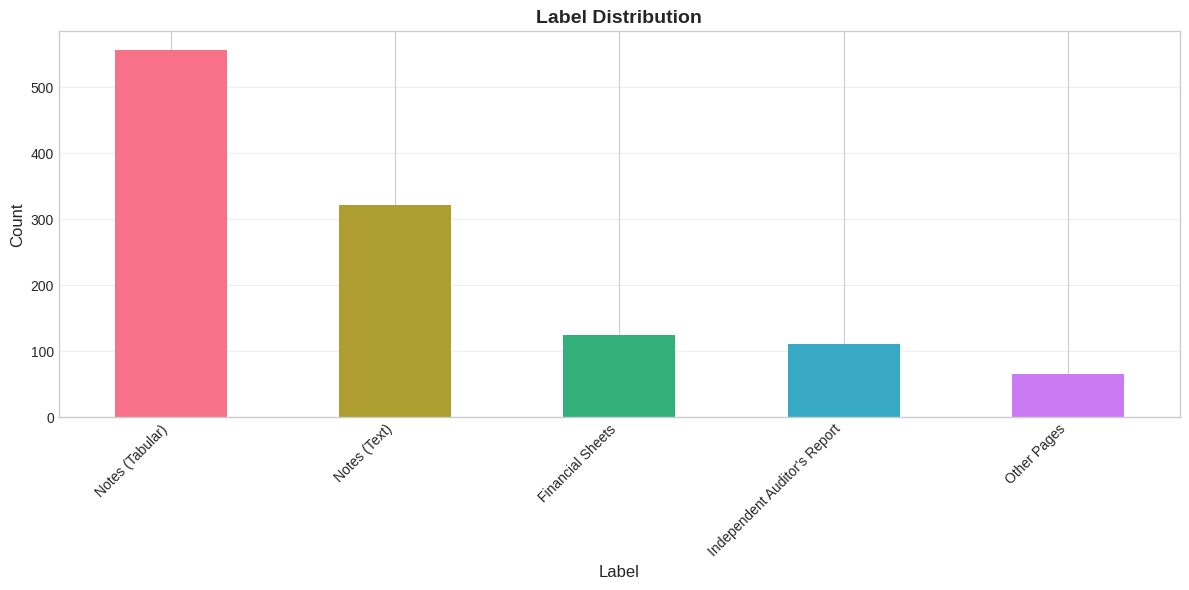

In [2398]:
# Verify labels
print("📊 Labeling Summary")

if os.path.exists(LABELS_FILE):
    labels_df = pd.read_csv(LABELS_FILE)

    if len(labels_df) > 0:
        total_images = len(image_files)
        labeled_count = len(labels_df)

        print(f"\n✅ Labeled pages: {labeled_count} / {total_images}")
        print(f"📈 Progress: {labeled_count/total_images*100:.1f}%")
        print(f"⏳ Remaining: {total_images - labeled_count}")

        print(f"\n📋 Label distribution:")
        label_counts = labels_df['label'].value_counts()
        for label, count in label_counts.items():
            percentage = count/labeled_count*100
            bar = '█' * int(percentage/2)
            print(f"  {label:30s}: {count:4d} ({percentage:5.1f}%) {bar}")

        # Visualize
        plt.figure(figsize=(12, 6))
        label_counts.plot(kind='bar', color=sns.color_palette('husl', len(label_counts)))
        plt.title('Label Distribution', fontweight='bold', fontsize=14)
        plt.xlabel('Label', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Show notes statistics if any
        if labels_df['notes'].notna().sum() > 0:
            print(f"\n📝 Pages with notes: {labels_df['notes'].notna().sum()}")

    else:
        print("\n⚠️  No labels found in file yet.")
else:
    print("\n⚠️  No labels.csv file found. Start labeling first!")